# Installation

In [2]:
%pip install scikit-image pandas matplotlib tqdm torchinfo tensorboard wandb scikit-learn vit-pytorch albumentations pytorch-msssim

  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorboard from https://files.pythonhosted.org/packages/3a/d0/b97889ffa769e2d1fdebb632084d5e8b53fc299d43a537acee7ec0c021a3/tensorboard-2.16.2-py3-none-any.whl.metadata
  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/53/7c/f3656d1ce3b916ea35f454c6a32b56342168c08baf09a0683df240ca2dce/wandb-0.16.5-py3-none-any.whl.metadata
  Obtaining dependency information for vit-pytorch from https://files.pythonhosted.org/packages/32/93/16e5cac205a700e75669e2eff4649c2a3630dba363b714d598c6e6019c6c/vit_pytorch-1.6.5-py3-none-any.whl.metadata
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/27/d1/98ac7a2d8cc826aff0ec1538e368346dc65bdada0cf39f6ebcd082f54dd1/albumentations-1.4.2

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'D:\\Anaconda\\Lib\\site-packages\\scikit_learn-1.4.1.post1.dist-info\\INSTALLERvxlydn7h.tmp'



  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/53/7c/f3656d1ce3b916ea35f454c6a32b56342168c08baf09a0683df240ca2dce/wandb-0.16.5-py3-none-any.whl.metadata
  Using cached wandb-0.16.5-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for vit-pytorch from https://files.pythonhosted.org/packages/32/93/16e5cac205a700e75669e2eff4649c2a3630dba363b714d598c6e6019c6c/vit_pytorch-1.6.5-py3-none-any.whl.metadata
  Using cached vit_pytorch-1.6.5-py3-none-any.whl.metadata (697 bytes)
  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/27/d1/98ac7a2d8cc826aff0ec1538e368346dc65bdada0cf39f6ebcd082f54dd1/albumentations-1.4.2-py3-none-any.whl.metadata
  Using cached albumentations-1.4.2-py3-none-any.whl.metadata (36 kB)
  Obtaining dependency information for GitPython!=3.1.29,>=1.0.0 from https://files.pythonhosted.org/packages/67/c7/995360c87dd74e27539ccbfecddfb58e08f140d849fcd7f35d2ed1a5f80f/GitP

# Imports

In [1]:
import os
import torch
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import format
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision.transforms as transforms
from util import run_experiment
from datasets import DeepLenseClassificationDataset
from vit_pytorch import ViT, SimpleViT
from vit_pytorch.mobile_vit import MobileViT
import multiprocessing

import albumentations as A
from albumentations.pytorch import ToTensorV2

# CONFIG

In [63]:
class CONFIG:
    BATCH_SIZE = 8
    EPOCHS = 30
    UPDATES = 6
    GAMMA_FACTOR = 0.5
    
    # limit the data to prototype faster
    DATA_LIMIT = 50
    
    CLASSES = 3
    ROUND_NUMBER = 3
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    TASK_NAME = "DeepLense2024_task1"
    PIN_MEMORY = False
    
    NUM_WORKERS = min(multiprocessing.cpu_count() - 5, BATCH_SIZE)


# weird thing on windows : if not set to 0, a dramatic performance drop (very not expected ?)
CONFIG.NUM_WORKERS = 0
    
# enabled for speed
torch.backends.cudnn.benchmark = True
print(f"Device : {CONFIG.DEVICE}")

Device : cuda


In [64]:
memory_start = psutil.virtual_memory()
print(f"RAM used : {format(memory_start.used)}, RAM free : {format(memory_start.free)}")

RAM used : 14.69GB, RAM free : 1.02GB


# Loading the dataset

In [117]:
import datasets
import importlib
from albumentations.pytorch import ToTensorV2
import util

importlib.reload(datasets)
importlib.reload(util)


train_transforms=A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.05, rotate_limit=180, p=0.9),
    A.GaussNoise(var_limit=0.05/3, p = 0.9),
    ToTensorV2()
    ])

val_transforms = A.Compose([
    ToTensorV2()
])

In [118]:
training_data = datasets.DeepLenseClassificationDataset(os.path.join(".", "Data", "Classification", "dataset", "train"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=0, std=1, transforms=train_transforms, preprocess_dataset=False)
train_dataloader = DataLoader(training_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=CONFIG.NUM_WORKERS, pin_memory=CONFIG.PIN_MEMORY)


mean, std = training_data.mean, training_data.std

val_data = datasets.DeepLenseClassificationDataset(os.path.join(".", "Data", "Classification", "dataset", "val"), data_limit=CONFIG.DATA_LIMIT, randomize_dataset=False,
                                               mean=0, std=1, transforms=val_transforms, preprocess_dataset=False)
val_dataloader = DataLoader(val_data, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=CONFIG.NUM_WORKERS, pin_memory=CONFIG.PIN_MEMORY)

memory = psutil.virtual_memory()
print(f"RAM used : {format(memory.used)}, RAM free : {format(memory.free)}, dataset used : {format(memory_start.free - memory.free)}")

loading numpy:   0%|          | 0/150 [00:00<?, ?it/s]

loading numpy: 100%|██████████| 150/150 [00:00<00:00, 4822.96it/s]

RAM used : 13.35GB, RAM free : 2.37GB, dataset used : -1445564416B


## Get the batch for prototyping

In [119]:
# Get the sample batch to prototype with models
x, y = next(iter(train_dataloader))
id2name = [v.split("/")[-1] for v in training_data.class_folders] 

In [120]:
from tqdm import tqdm

# Get the sample batch to prototype with models
for e in range(3):
    for x, y in tqdm(train_dataloader):
        pass    

100%|██████████| 19/19 [00:00<00:00, 106.76it/s]


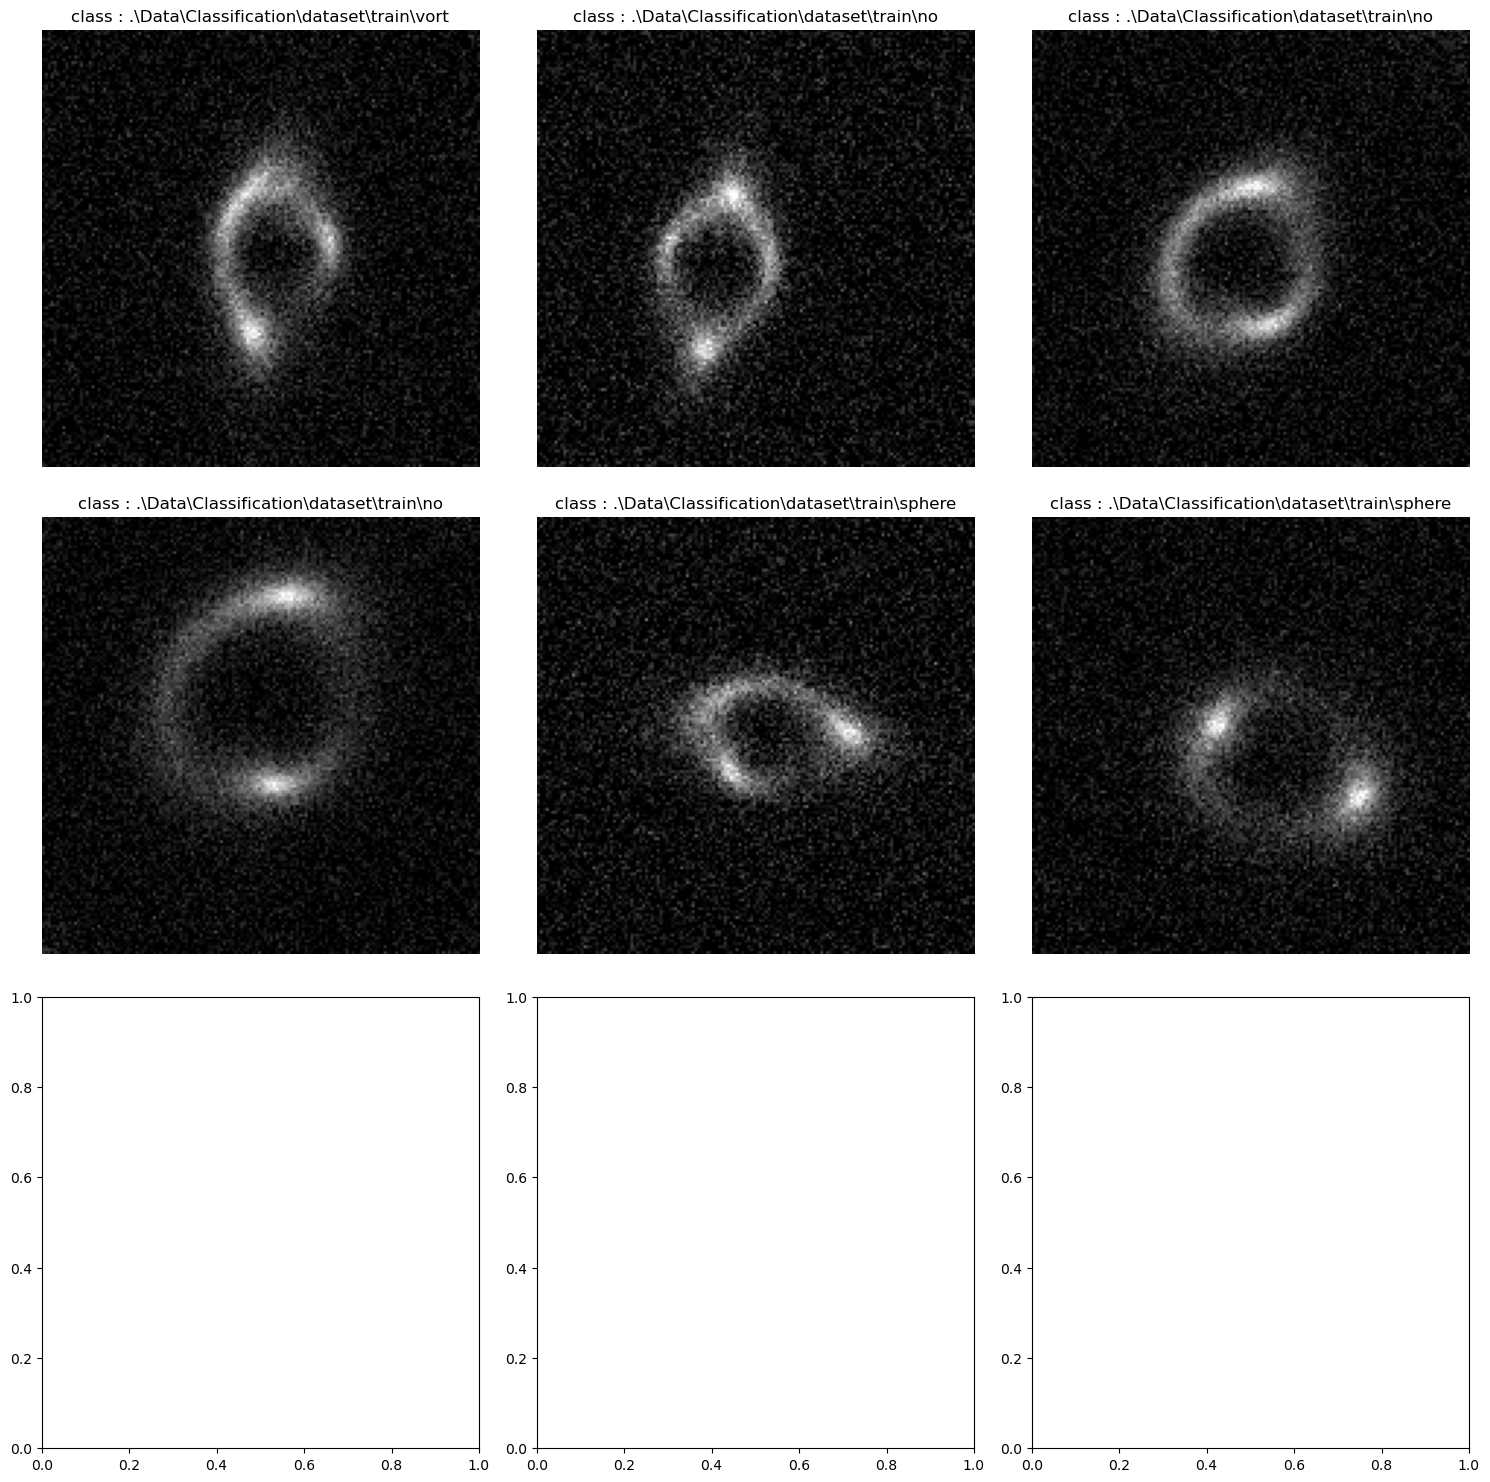

In [121]:
import matplotlib.pyplot as plt 
import math 
plot_size = math.ceil(math.sqrt(CONFIG.BATCH_SIZE))

fig, axes = plt.subplots(plot_size, plot_size, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i >= len(x):
        break
    # Convert torch tensor to numpy array and transpose channels if necessary
    
    img = x[i].numpy().transpose(1, 2, 0)
        
    ax.imshow(img, cmap="gray")
    ax.set_title(f"class : {id2name[y[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Resnet-based

In [59]:
from torchvision.models import resnet18, resnet34, resnet50

class CNN_resnet(nn.Module):
    def __init__(self, base="resnet18"):
        super(CNN_resnet, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        if base.lower() == "resnet18":
            self.backend = resnet18(None)
        elif base.lower() == "resnet34":
            self.backend = resnet34(None)
        elif base.lower() == "resnet50":
            self.backend = resnet50(None)
        else:
            raise Exception("incorrect backbone")
    
        
        # make one channel 
        self.backend.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

        # output 3 classes
        self.backend.fc = nn.Linear(512, CONFIG.CLASSES, bias=True)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

# Create the CNN model instance
model = CNN_resnet(base="resnet18").to(CONFIG.DEVICE)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


## Resnet18

In [70]:
model(x.float().to(CONFIG.DEVICE)).shape
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                        Param #
CNN_resnet                                    --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

In [102]:
import util
import importlib

importlib.reload(util)

util.run_experiment(Model=CNN_resnet, 
               run_name="resnet18", 
               model_parameters={"base":"resnet18"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "resnet18.pth"),
               base_lr=1e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

EPOCH : 0, average loss : 1.2151469870617515, lr=7.156560487081053e-05: 100%|██████████| 19/19 [00:00<00:00, 28.70it/s]
examples seen so far : 150, accuracy = 0.333, AUC ROC = 0.479: 100%|██████████| 19/19 [00:00<00:00, 86.57it/s]
examples seen so far : 150, accuracy = 0.333, AUC ROC = 0.491: 100%|██████████| 19/19 [00:00<00:00, 73.04it/s]


Saving metric with accuracy=0.3333333333333333 (previous : 0)


EPOCH : 1, average loss : 1.1359024800752338, lr=2.03269040750895e-05: 100%|██████████| 19/19 [00:00<00:00, 56.97it/s]  
examples seen so far : 150, accuracy = 0.333, AUC ROC = 0.525: 100%|██████████| 19/19 [00:00<00:00, 79.56it/s]
examples seen so far : 150, accuracy = 0.327, AUC ROC = 0.481: 100%|██████████| 19/19 [00:00<00:00, 109.37it/s]
EPOCH : 2, average loss : 1.0904249078349064, lr=1.7005243352409378e-05: 100%|██████████| 19/19 [00:00<00:00, 52.57it/s]
examples seen so far : 150, accuracy = 0.393, AUC ROC = 0.551: 100%|██████████| 19/19 [00:00<00:00, 80.69it/s]
examples seen so far : 150, accuracy = 0.353, AUC ROC = 0.52: 100%|██████████| 19/19 [00:00<00:00, 111.84it/s] 


Saving metric with accuracy=0.35333333333333333 (previous : 0.3333333333333333)


EPOCH : 3, average loss : 1.1225530913001613, lr=6.619104492241898e-05: 100%|██████████| 19/19 [00:00<00:00, 52.34it/s] 
examples seen so far : 150, accuracy = 0.367, AUC ROC = 0.556: 100%|██████████| 19/19 [00:00<00:00, 91.06it/s]
examples seen so far : 150, accuracy = 0.333, AUC ROC = 0.517: 100%|██████████| 19/19 [00:00<00:00, 101.67it/s]
EPOCH : 4, average loss : 1.1184944918281154, lr=9.991120277927307e-05: 100%|██████████| 19/19 [00:00<00:00, 56.44it/s]
examples seen so far : 150, accuracy = 0.393, AUC ROC = 0.563: 100%|██████████| 19/19 [00:00<00:00, 76.97it/s]
examples seen so far : 150, accuracy = 0.347, AUC ROC = 0.497: 100%|██████████| 19/19 [00:00<00:00, 108.75it/s]
EPOCH : 5, average loss : 1.124527190860949, lr=7.156560487081114e-05: 100%|██████████| 19/19 [00:00<00:00, 51.86it/s] 
examples seen so far : 150, accuracy = 0.34, AUC ROC = 0.561: 100%|██████████| 19/19 [00:00<00:00, 81.65it/s] 
examples seen so far : 150, accuracy = 0.333, AUC ROC = 0.517: 100%|██████████| 19

Saving metric with accuracy=0.38 (previous : 0.35333333333333333)


EPOCH : 12, average loss : 1.0901767580132735, lr=1.700524335240938e-05: 100%|██████████| 19/19 [00:00<00:00, 53.35it/s] 
examples seen so far : 150, accuracy = 0.353, AUC ROC = 0.537: 100%|██████████| 19/19 [00:00<00:00, 72.93it/s]
examples seen so far : 150, accuracy = 0.367, AUC ROC = 0.511: 100%|██████████| 19/19 [00:00<00:00, 107.03it/s]
EPOCH : 13, average loss : 1.0616495546541715, lr=6.619104492241903e-05: 100%|██████████| 19/19 [00:00<00:00, 54.21it/s] 
examples seen so far : 150, accuracy = 0.42, AUC ROC = 0.597: 100%|██████████| 19/19 [00:00<00:00, 71.94it/s] 
examples seen so far : 150, accuracy = 0.307, AUC ROC = 0.502: 100%|██████████| 19/19 [00:00<00:00, 97.48it/s]
EPOCH : 14, average loss : 1.1152330072302568, lr=9.991120277927319e-05: 100%|██████████| 19/19 [00:00<00:00, 54.27it/s]
examples seen so far : 150, accuracy = 0.367, AUC ROC = 0.52: 100%|██████████| 19/19 [00:00<00:00, 78.87it/s] 
examples seen so far : 150, accuracy = 0.34, AUC ROC = 0.491: 100%|██████████| 

Saving metric with accuracy=0.38666666666666666 (previous : 0.38)


EPOCH : 37, average loss : 1.0624875394921554, lr=1.7005243352409805e-05: 100%|██████████| 19/19 [00:00<00:00, 51.05it/s]
examples seen so far : 150, accuracy = 0.413, AUC ROC = 0.575: 100%|██████████| 19/19 [00:00<00:00, 74.20it/s]
examples seen so far : 150, accuracy = 0.347, AUC ROC = 0.517: 100%|██████████| 19/19 [00:00<00:00, 112.55it/s]
EPOCH : 38, average loss : 1.0865238842211271, lr=6.619104492242168e-05: 100%|██████████| 19/19 [00:00<00:00, 53.10it/s] 
examples seen so far : 150, accuracy = 0.447, AUC ROC = 0.63: 100%|██████████| 19/19 [00:00<00:00, 86.26it/s] 
examples seen so far : 150, accuracy = 0.32, AUC ROC = 0.506: 100%|██████████| 19/19 [00:00<00:00, 94.28it/s]
EPOCH : 39, average loss : 1.0976379262773615, lr=9.99112027792777e-05: 100%|██████████| 19/19 [00:00<00:00, 58.43it/s] 
examples seen so far : 150, accuracy = 0.367, AUC ROC = 0.551: 100%|██████████| 19/19 [00:00<00:00, 76.88it/s]
examples seen so far : 150, accuracy = 0.38, AUC ROC = 0.528: 100%|██████████| 1

## Resnet34

In [ ]:
# Create the CNN model instance
model = CNN_resnet(base="resnet34").to(CONFIG.DEVICE)
model(x.float().to(CONFIG.DEVICE)).shape
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_resnet, 
               run_name="resnet34", 
               model_parameters={"base":"resnet34"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "resnet34.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# Resnet50

In [ ]:
# Create the CNN model instance
model = CNN_resnet(base="resnet50").to(CONFIG.DEVICE)
model(x.float().to(CONFIG.DEVICE)).shape
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_resnet, 
               run_name="resnet34", 
               model_parameters={"base":"resnet50"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "resnet50.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# VGG-based

In [15]:
from torchvision.models import vgg11, vgg13, vgg16, vgg19

class CNN_VGG(nn.Module):
    def __init__(self, base="vgg11"):
        super(CNN_VGG, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        if base.lower() == "vgg11":
            self.backend = vgg11(None)
        elif base.lower() == "vgg13":
            self.backend = vgg13(None)
        elif base.lower() == "vgg16":
            self.backend = vgg16(None)
        elif base.lower() == "vgg19":
            self.backend = vgg19(None)
        else:
            raise Exception("incorrect backbone")
    
        
        # make one channel 
        self.backend.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)

        # output 3 classes
        self.backend.classifier[-1] = nn.Linear(4096, out_features=CONFIG.CLASSES)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

## VGG11

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg11").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG11", 
               model_parameters={"base":"VGG11"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG11.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

## VGG13

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg13").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG13", 
               model_parameters={"base":"VGG13"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG13.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

## VGG16

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg16").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG16", 
               model_parameters={"base":"VGG16"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG16.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

## VGG19

In [ ]:
# Create the CNN model instance
model = CNN_VGG(base="vgg19").to(CONFIG.DEVICE)
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

In [ ]:
util.run_experiment(Model=CNN_VGG, 
               run_name="VGG19", 
               model_parameters={"base":"VGG19"},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "VGG19.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# ConvNeXt

In [19]:
from torchvision.models import convnext_tiny

class CNN_CONVNEXT(nn.Module):
    def __init__(self):
        super(CNN_CONVNEXT, self).__init__()
        # the resnet model was trained on imagenet, it's not really applicable in this situation
        self.backend = convnext_tiny(None)    
        
        # make one channel 
        self.backend.features[0][0] = nn.Conv2d(1, 96, kernel_size=(4,4), stride=(4,4))

        # output 3 classes
        self.backend.classifier[-1] = nn.Linear(768, out_features=CONFIG.CLASSES)
        

    def forward(self, x):
        # Applying convolutional layers with ReLU and pooling
        x = self.backend(x)
        return x

model = CNN_CONVNEXT()
summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

/home/mlewand/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Layer (type:depth-idx)                             Param #
CNN_CONVNEXT                                       --
├─ConvNeXt: 1-1                                    --
│    └─Sequential: 2-1                             --
│    │    └─Conv2dNormActivation: 3-1              1,824
│    │    └─Sequential: 3-2                        237,888
│    │    └─Sequential: 3-3                        74,112
│    │    └─Sequential: 3-4                        918,144
│    │    └─Sequential: 3-5                        295,680
│    │    └─Sequential: 3-6                        10,817,280
│    │    └─Sequential: 3-7                        1,181,184
│    │    └─Sequential: 3-8                        14,289,408
│    └─AdaptiveAvgPool2d: 2-2                      --
│    └─Sequential: 2-3                             --
│    │    └─LayerNorm2d: 3-9                       1,536
│    │    └─Flatten: 3-10                          --
│    │    └─Linear: 3-11                           2,307
Total params: 27,819,363
T

In [ ]:
util.run_experiment(Model=CNN_CONVNEXT, 
               run_name="CNN_CONVNEXT", 
               model_parameters={},
               epochs=50,
               learning_rate=1e-4,
               optimizer="Adam",
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               savepath=os.path.join("models", "CNN_CONVNEXT.pth"),
               base_lr=3e-4,
               min_lr=1e-5,
               scheduler_en=False,
               cfg=CONFIG,
               metric_keyword="accuracy",
               lr_steps=len(train_dataloader) // 2,
               WANDB_ON=False)

# VIT 

In [44]:
model = ViT(image_size = 150,
        channels=1,
        patch_size = 15,
        num_classes = CONFIG.CLASSES,
        dim = 1024,
        depth = 6,
        heads = 16,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1)

summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                             Param #
ViT                                                104,448
├─Sequential: 1-1                                  --
│    └─Rearrange: 2-1                              --
│    └─LayerNorm: 2-2                              450
│    └─Linear: 2-3                                 231,424
│    └─LayerNorm: 2-4                              2,048
├─Dropout: 1-2                                     --
├─Transformer: 1-3                                 --
│    └─LayerNorm: 2-5                              2,048
│    └─ModuleList: 2-6                             --
│    │    └─ModuleList: 3-1                        8,396,800
│    │    └─ModuleList: 3-2                        8,396,800
│    │    └─ModuleList: 3-3                        8,396,800
│    │    └─ModuleList: 3-4                        8,396,800
│    │    └─ModuleList: 3-5                        8,396,800
│    │    └─ModuleList: 3-6                        8,396,800
├─Identity: 1-4   

## Simple ViT

In [45]:
model = SimpleViT(image_size = 150,
        channels=1,
        patch_size = 15,
        num_classes = CONFIG.CLASSES,
        dim = 1024,
        depth = 6,
        heads = 16,
        mlp_dim = 2048)

summary(model, input_shape=(CONFIG.BATCH_SIZE, 150, 150, 1))

Layer (type:depth-idx)                             Param #
SimpleViT                                          --
├─Sequential: 1-1                                  --
│    └─Rearrange: 2-1                              --
│    └─LayerNorm: 2-2                              450
│    └─Linear: 2-3                                 231,424
│    └─LayerNorm: 2-4                              2,048
├─Transformer: 1-2                                 --
│    └─LayerNorm: 2-5                              2,048
│    └─ModuleList: 2-6                             --
│    │    └─ModuleList: 3-1                        8,395,776
│    │    └─ModuleList: 3-2                        8,395,776
│    │    └─ModuleList: 3-3                        8,395,776
│    │    └─ModuleList: 3-4                        8,395,776
│    │    └─ModuleList: 3-5                        8,395,776
│    │    └─ModuleList: 3-6                        8,395,776
├─Identity: 1-3                                    --
├─Linear: 1-4          